# Setup

## Imports

In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import arviz as az
import pystan
import seaborn as sns
import pandas as pd

from scipy.stats import gaussian_kde
from sklearn.mixture import GaussianMixture

import os
from collections import OrderedDict, defaultdict

sns.set_style('ticks')
sns.set_context('notebook')
sns.set_palette('colorblind')

## Stats utilities

In [3]:
def ComputeSymCI(samples, ci=0.9):
    """ Symmetric CI.
    """
    lo = np.percentile(samples, 100.0 * (1-ci)*0.5)
    hi = np.percentile(samples, 100.0 * (1-(1-ci)*0.5))
    return hi - lo

In [4]:
def ComputeHPD(Samples, p=0.9):
    """ Find p-% HPD.
    """
    NewSamples = sort(Samples)
    n = len(Samples)
    m = int((1-n)*p)
    i = np.argmin(NewSamples[-m:] - NewSamples[:m])
    return (NewSamples[i], NewSamples[i+int(n*p)])

In [5]:
def ComputeHPD2(Samples, target=0, dp=0.00005, tol=0.001):
    """ Find HPD at target.
    """
    ps = np.arange(dp, 1, dp)
    for p in ps:
        try:
            lo, hi = ComputeHPD(Samples, p)
            lo_dist = lo - target
            hi_dist = hi - target
            if np.abs(hi_dist) < tol or np.abs(lo_dist) < tol:
                break
        except IndexError:
            pass
        except ValueError:
            pass
    if p == ps[-1]:
        # try with a worse tolerance
        return ComputeHPD2(Samples, target=0, dp=0.0005, tol=tol*2)
    return p, lo_dist, hi_dist

In [6]:
def HDI_from_MCMC(posterior_samples, credible_mass):
    import pymc3
    # Computes highest density interval from a sample of representative values,
    # estimated as the shortest credible interval
    # Takes Arguments posterior_samples (samples from posterior) and credible mass (normally .95)
    sorted_points = sorted(posterior_samples)
    ciIdxInc = np.ceil(credible_mass * len(sorted_points)).astype('int')
    nCIs = len(sorted_points) - ciIdxInc
    ciWidth = [0]*nCIs
    for i in range(0, nCIs):
        ciWidth[i] = sorted_points[i + ciIdxInc] - sorted_points[i]
    HDImin = sorted_points[ciWidth.index(min(ciWidth))]
    HDImax = sorted_points[ciWidth.index(min(ciWidth))+ciIdxInc]
    return(HDImin, HDImax)

## Plotting utilities

In [7]:
def get_label(param):
    if param == 'dchiMinus2':
        l = r'$\delta\hat{\varphi}_{-2}$ {\fontsize{16pt}{3em}{ $(\times 20)$}'
    elif 'chi' in param:
        l =  param.replace('dchi', r'$\delta\hat{\varphi}_{') + '}$'
    elif 'alpha' in param:
        l = param.replace('dalpha', r'$\delta\hat{\alpha}_{') + '}$'
    else:
        l = param.replace('dbeta', r'$\delta\hat{\beta}_{') + '}$'
    return l 


def get_short_label(param):
    if 'chi' in param:
#         l = param.replace('Minus', '').replace('dchi', '')
        l =  param.replace('Minus', '-').replace('dchi', r'$\varphi_{') + '}$'
    elif 'alpha' in param:
        l = param.replace('dalpha', r'$\alpha_{') + '}$'
    else:
        l = param.replace('dbeta', r'$\beta_{') + '}$'
    return l 

In [8]:
wf_names = ['GW150914', 'GW151012','GW151226', 'GW170104', 'GW170608', 'GW170729','GW170809', 'GW170814', 'GW170818','GW170823']
# wf_colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#6a3d9a','#ffff99']

def get_ls(event):
    if event in ['GW170608', 'GW151012', 'GW170814', 'GW170818', 'GW170823']:
        return '--'
    else:
        return '-'
    
# From O2 catalog paper
def get_event_colors():
    """Define colors for GW events.
    
    Let's use a customized version of HUSL, http://www.hsluv.org.
    As a starting point choose

    H = np.arange(11) * 360.0/12.
    S = 100
    L = 50
    
    The colors are too dark and greens are hard to distinguish. 
    Tweak the spacing in hue and increase luminosity to 60 ~ 70. 
    This is very similar to out of the box HUSL.
    Also provide a version where we desaturate every second color to S ~ 50 - 70.
    """
    colors_custom_full_S = ['#ff6c91', '#f77b00', '#c59700', '#9da500', '#55b300', '#00b47d', '#00b1a4', '#00aec2', '#00a7f0', '#9f8eff', '#ea65ff']
    colors_custom_desat = ['#ff6c91', '#d48d6f', '#c59700', '#9da355', '#55b300', '#58ae87', '#00b1a4', '#5ca9b8', '#00a7f0', '#9e94e2', '#ea65ff']

    event_list = ['GW170817', 'GW170608', 'GW151226', 'GW151012', 'GW170104', 'GW170814',
                  'GW170809', 'GW170818', 'GW150914', 'GW170823', 'GW170729']

    n = len(event_list)
    event_colors = defaultdict(str)
    colors = colors_custom_desat
    for k, v in zip(event_list, colors):
        event_colors[k] = v
    event_colors_F = dict(event_colors)
    del event_colors_F['GW170817']
    event_colors_P = event_colors
    
    return event_colors, event_colors_P, event_colors_F

_, color_dict, _ =  get_event_colors()

Run the cell below (convert to Python code) if you want to make plots scale to columns.

```python
# make plots to fit the LaTex column size but rescale them for ease of display here
scale_factor = 4

fig_width_pt = scale_factor*246.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
fig_ratio = (np.sqrt(5)-1.0)/2.0         # Plot aspect ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*fig_ratio       # height in inches
fig_size = [fig_width, fig_height]

# LaTex text font sizse in points (rescaled as above)
fs = scale_factor*8  # general
lfs = 0.9*fs  # legend
tfs0 = 0.8*fs  # ax0 ticks
tfs12 = 0.6*fs # ax1/2 ticks

mplparams = {
    'text.usetex': True,  # use LaTeX for all text
    'axes.linewidth': 1,  # set axes linewidths to 0.5
    'axes.grid': False,  # add a grid
    'axes.labelweight': 'normal',
    'font.size': fs,
    'font.serif': 'Computer Modern Roman',
    'xtick.labelsize': fs,
    'ytick.labelsize': fs,
}
matplotlib.rcParams.update(mplparams)

# sns.set(font_scale=1.5)
sns.axes_style("white")
sns.set_style("ticks", {'font.family': 'serif'})
```

# Intro

We want to see if we can (in a principled way, of course) stack "tests of GR" expressed as factors modifying a particular pN coefficient to extract information about or bound possible deviations.

In the absence of a model for how the deviations should behave as a function of the parameters of each system, a natural test is to look simultaneously for both

 * A shared "offset" such that the devaition parameter does not center around zero for the ensemble of systems
 * A measurable dispersion in the deviation parameter (with or without an offset) that suggests it is not identically zero for each system.
 
We can conduct such a search by fitting a hierarchical model (sometimes called a "population model," a "multi-level model," or an "extreme deconvolution") to the deviation parameters.  The simplest such model imposes a Gaussian population model with mean $\mu$ and s.d. $\sigma$; then the parameter $\mu$ fits the population mean deviation and $\sigma$ fits the population dispersion.  In GR, $\mu = \sigma = 0$; any measurably non-zero value indicates some deviation from GR in the population.

The model here is very similar to the classic "[eight schools](https://andrewgelman.com/2014/01/21/everything-need-know-bayesian-statistics-learned-eight-schools/)" problem, but here we do not assume that the sampling distribution for the measurements (i.e. the likelihood function) is Gaussian, instead treating it as a KDE over samples drawn for each observation.

For more on hierarchical/multi-level modelling (aka "extreme deconvolution") see any good stats textbook or [Mandel (2010)](https://ui.adsabs.harvard.edu/#abs/2010PhRvD..81h4029M/abstract), [Bovy, Hogg & Roweis (2010)](http://inspirehep.net/record/921489), or [Hogg, Myers & Bovy (2010)](https://ui.adsabs.harvard.edu/#abs/2010ApJ...725.2166H/abstract).

Assuming we have $i = 1, \ldots, N$ systems each with (GR) parameters $\theta_i$ and measured data $d_i$ and $\chi_i$ is the deviation parameter for each system (with $\chi_i = 0$ the GR prediciton), the graphical model we have is:

Choosing to use marginalized samples for $\chi_i$ alone is equivalent to integrating out the GR parameters according to the prior; to the extent that the prior does not match the true population, one may expect to eventually see "artificial" deviations from GR that correct the mis-match between population and prior.  This can be ameloriated by either (a) incorporating the tests of GR into a full population analysis that simultaneously fits the population for $\theta$ with enough degrees of freedom to match sufficiently well the true population to eliminate this bias or (b) replacing the default prior with one from a pure-GR population analysis.  (b) is easier, but has the defect that the correlations (if any) between the population and the modified GR parameters are not explored.

It is straightforward to just re-weight the posterior samples over $\chi_i$ by the ratio of the Gaussian with $\mu$-$\sigma$ to the prior used in the original analysis

The below Stan code implements this model.  Given posterior samples over $\chi_i$ for $N$ events, assumed to be drawn from a flat prior on $\chi_i$ (so their density is proportional to the likelihood), it samples from the posterior in $\mu$ and $\sigma$.  There is really no good reason to sample over a 2D posterior, except that it's quick and easy to write the Stan model and harder to write a debugged gridded posterior evaluation:

# Preprocessing

## Simulate data

In [9]:
all_events = ['150914', '151012', '151226', '170104', '170608', 
              '170729', '170809', '170814', '170818', '170823']
all_events = [str(i) for i in range(100)]

In [10]:
nsamp = 1000
dmchi_samples = OrderedDict({})
for event in all_events:
    # simulate samples from 2D normal
    dmchi_samples[event] = np.random.normal(0, 1, (2, 1)) +\
                           np.random.normal(0, 1, (2, nsamp))

Plot result.

In [11]:
dms = np.array([v[0] for v in dmchi_samples.values()])
dchis = np.array([v[1] for v in dmchi_samples.values()])

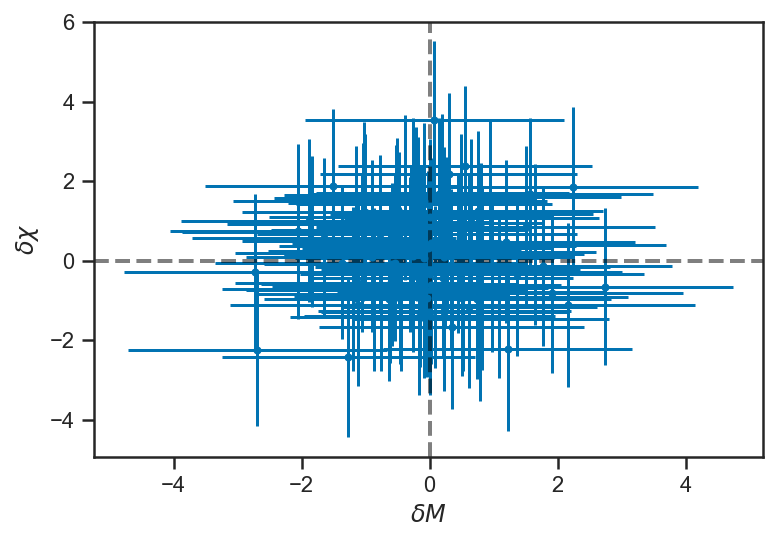

In [12]:
xarray = np.arange(-1, 1, 0.1)

dm_median = np.array([np.median(v[0]) for v in dmchi_samples.values()])
dm_std = np.array([np.std(v[0]) for v in dmchi_samples.values()])
dchi_median = np.array([np.median(v[1]) for v in dmchi_samples.values()])
dchi_std = np.array([np.std(v[1]) for v in dmchi_samples.values()])

plt.errorbar(dm_median, dchi_median, xerr=2*dm_std, yerr=2*dchi_std, fmt='.')

plt.xlabel(r'$\delta M$')
plt.ylabel(r'$\delta \chi$')
plt.axvline(0, c='k', ls='--', lw=2, alpha=0.5)
plt.axhline(0, c='k', ls='--', lw=2, alpha=0.5)
# plt.axhline(1,c='k')
plt.show()

## Fit KDE

In [13]:
from tqdm.notebook import tqdm

In [14]:
Ngm = np.arange(1, 10)
MeanScores = []
for ng in tqdm(Ngm):
    gmm = GaussianMixture(ng)
    scores = []
    for dm, dchi in zip(dms, dchis):
        c = permutation(len(dm))
        n2 = len(c)//2
        gmm.fit(np.column_stack((dm[c[:n2]], dchi[c[:n2]])))
        scores.append(gmm.score(np.column_stack((dm[c[n2:]], dchi[c[n2:]]))))
    MeanScores.append(np.mean(scores))
MeanScores = np.array(MeanScores)

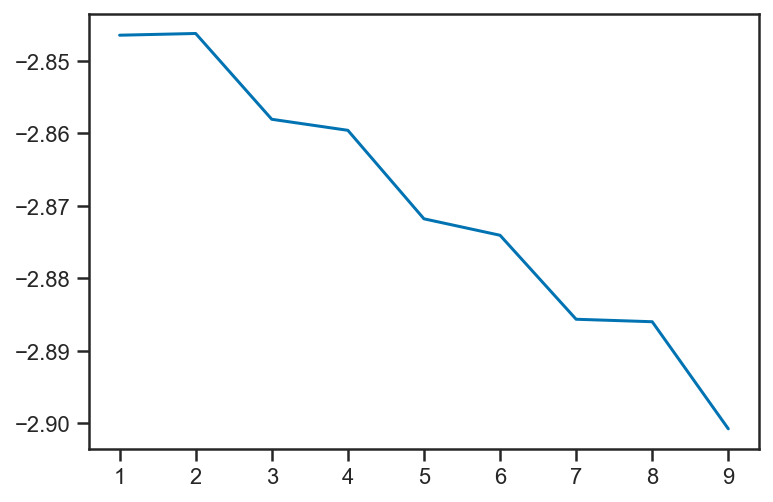

In [15]:
plt.plot(Ngm, MeanScores)
plt.show()

In [16]:
# one Gaussian should be enough for our fake data, but see
# https://git.ligo.org/katerina.chatziioannou/bnspopulation/blob/master/PopulationScripts/Population.ipynb?expanded=true&viewer=rich

NC=1

GMMData = []
for dm,dchi in zip(tqdm(dms), dchis):
    g = GaussianMixture(NC)
    GMMData.append(g.fit(np.column_stack((dm, dchi))))

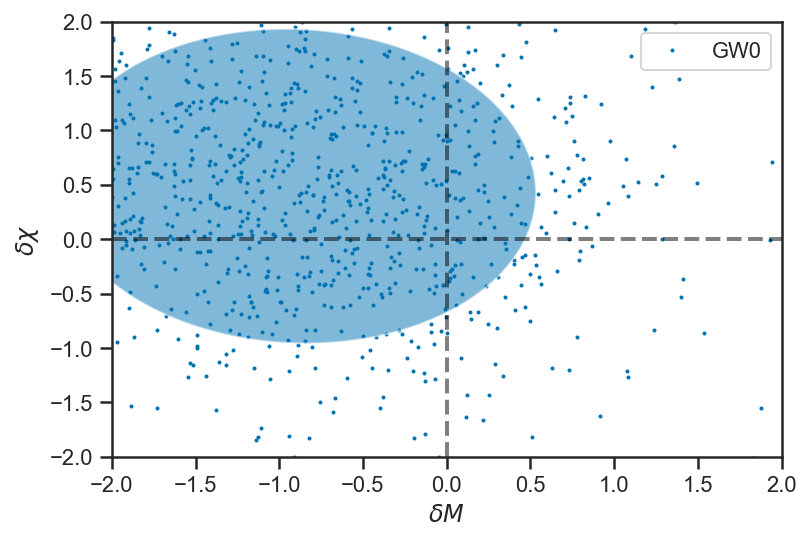

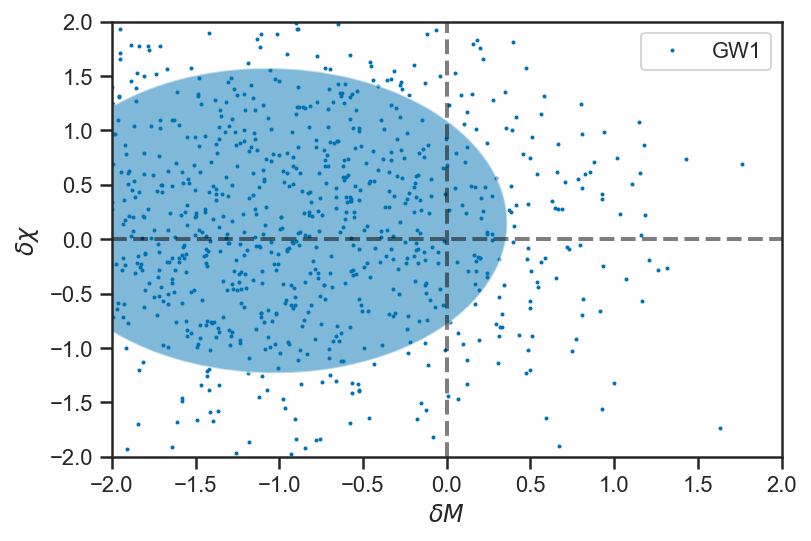

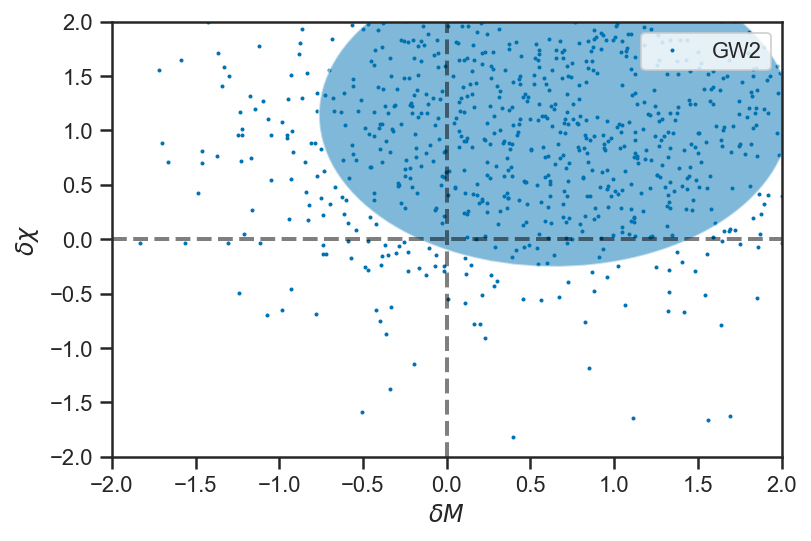

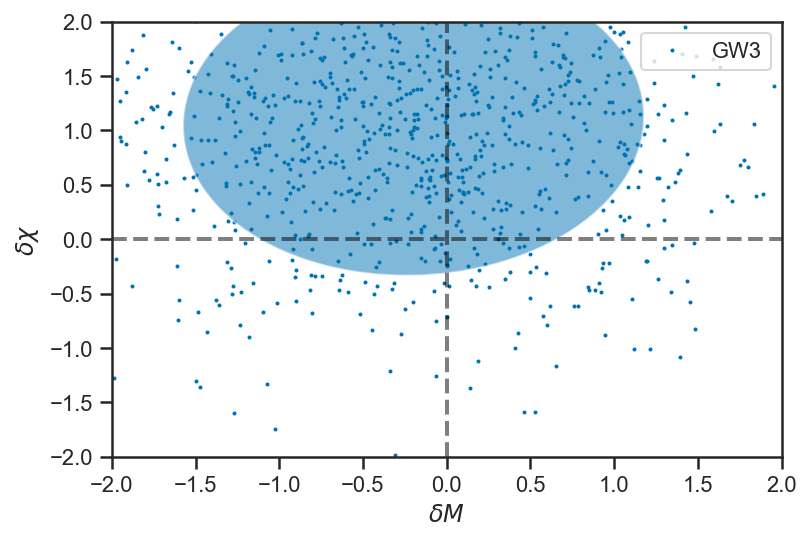

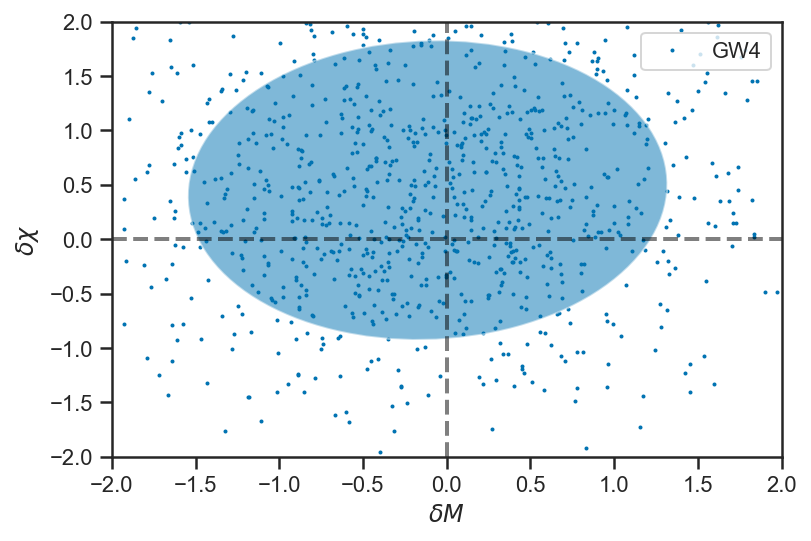

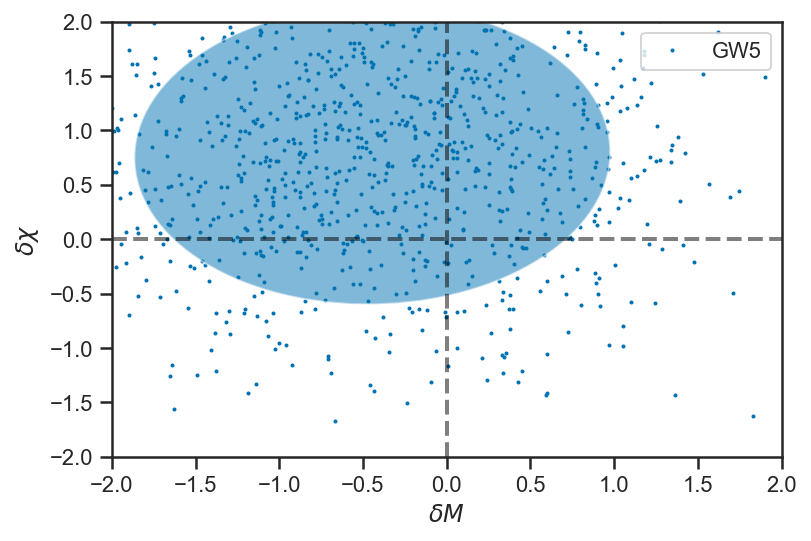

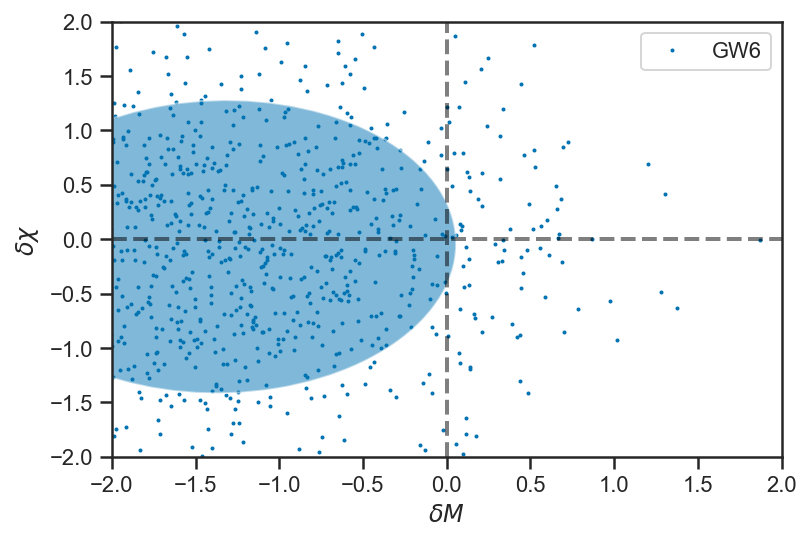

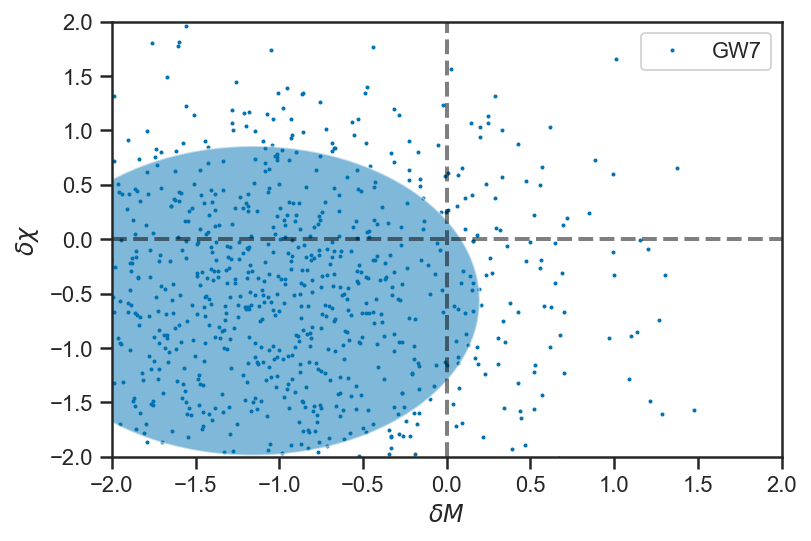

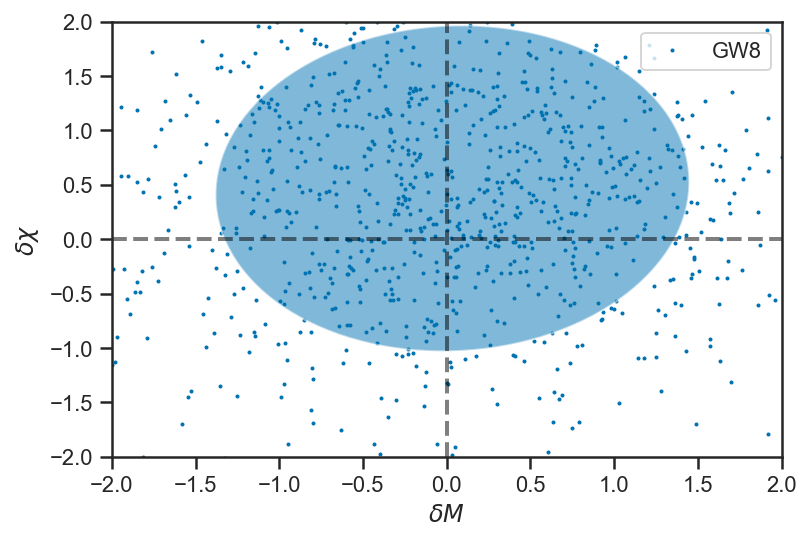

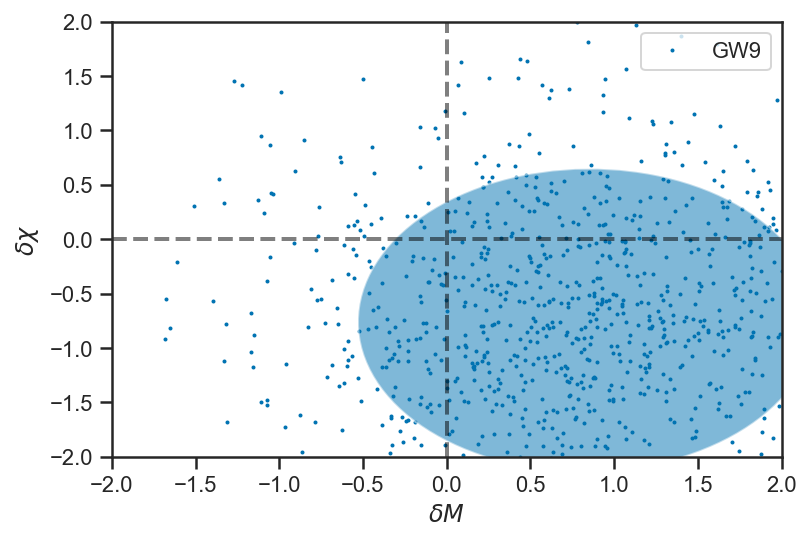

In [17]:
def plot_results(means, covariances):
    splot = plt.subplot(1,1,1)
    for i, (mean, covar) in enumerate(zip(
            means, covariances)):
        v, w = np.linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / np.linalg.norm(w[0])
        
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = matplotlib.patches.Ellipse(mean, v[0], v[1], 180. + angle)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)
    
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.axvline(0, c='k', ls='--', lw=2, alpha=0.5)
    plt.axhline(0, c='k', ls='--', lw=2, alpha=0.5)
    plt.xlabel(r'$\delta M$')
    plt.ylabel(r'$\delta \chi$')
    
for i,event in enumerate(all_events[:10]):
    plot_results(GMMData[i].means_, GMMData[i].covariances_)
    plt.plot(dms[i], dchis[i],'.',ms=2,zorder=-10, label='GW'+event)
    plt.legend(loc='upper right')
    plt.show()

## Fit

In [28]:
model = pystan.StanModel(file='hierGRtest2D.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_62cf7ec314e89c232401a96a37b328a9 NOW.


In [29]:
data = {
    'Nobs': len(all_events),

    'NC': NC,
    'weights': [g.weights_ for g in GMMData],
    'means': [g.means_ for g in GMMData],
    'covs': [g.covariances_ for g in GMMData],
}

Ignore the n_eff and Rhat warnings: the post-processing doesn't know that one of our parameters is a correlation matrix, so *always* has 1's on the diagonal.  The chain of constant 1's confuses the n_eff and Rhat computations, leading to the error.

In [30]:
Fit = model.sampling(data=data, chains=4, iter=2000)

/Users/wfarr/anaconda3/envs/hiergrtest2d/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/wfarr/anaconda3/envs/hiergrtest2d/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


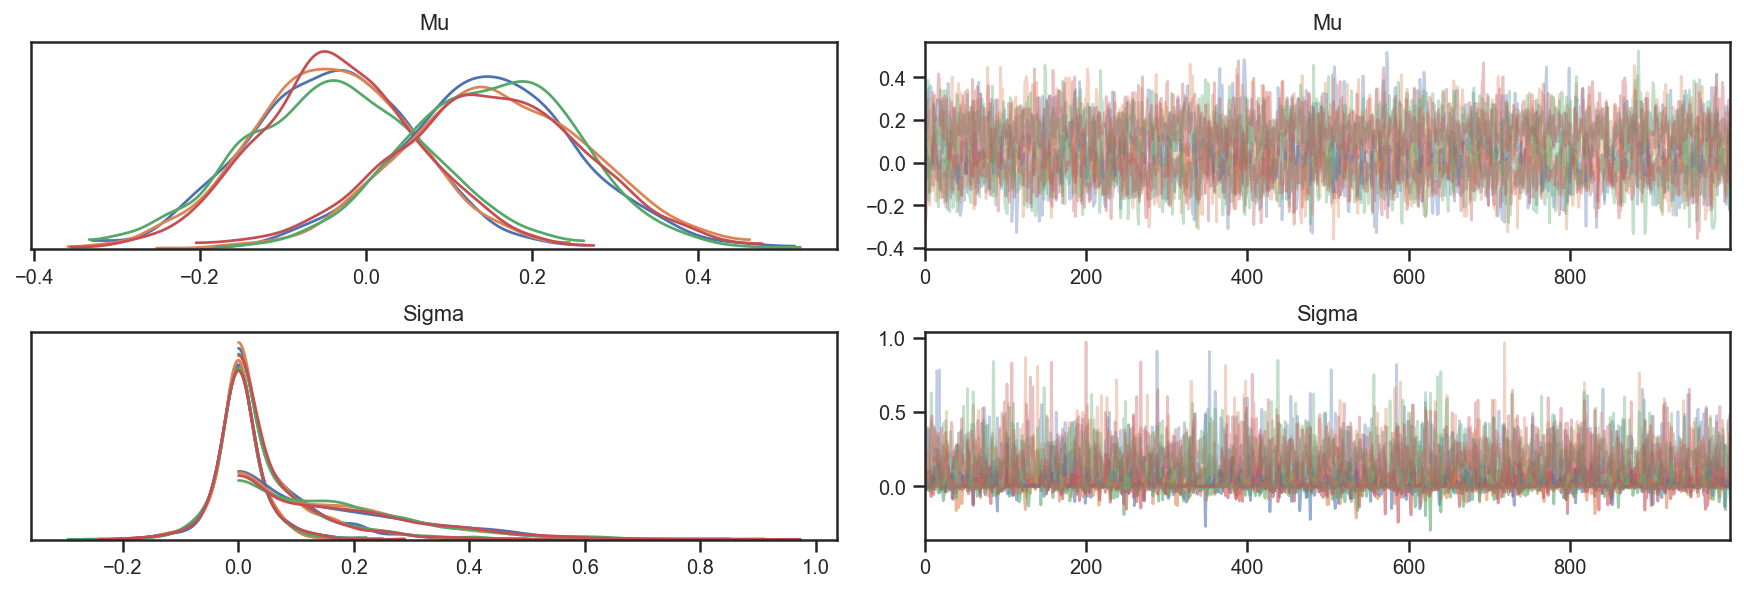

In [31]:
az.plot_trace(Fit,
              var_names=['Mu', 'Sigma'],
              compact=True);

In [32]:
result = az.convert_to_inference_data(Fit)
result.posterior.data_vars

Data variables:
    Mu        (chain, draw, Mu_dim_0) float64 -0.007556 0.2257 ... 0.08283
    Lhat      (chain, draw, Lhat_dim_0, Lhat_dim_1) float64 1.0 0.0 ... 0.754
    s         (chain, draw, s_dim_0) float64 0.3631 0.5437 ... 0.04274 0.4326
    Sigma     (chain, draw, Sigma_dim_0, Sigma_dim_1) float64 0.1319 ... 0.1871
    L         (chain, draw, L_dim_0, L_dim_1) float64 0.3631 0.0 ... 0.3261
    xpop      (chain, draw, xpop_dim_0) float64 0.1288 1.135 ... -0.169 -0.3339
    dMpop     (chain, draw) float64 0.1288 -0.09048 0.0327 ... 0.08172 -0.169
    dchipop   (chain, draw) float64 1.135 0.8328 -0.209 ... 0.5467 -0.3339
    xtrue     (chain, draw, xtrue_dim_0, xtrue_dim_1) float64 0.1085 ... 0.3985
    dMtrue    (chain, draw, dMtrue_dim_0) float64 0.1085 0.5372 ... -0.1312
    dchitrue  (chain, draw, dchitrue_dim_0) float64 -0.1445 -0.03331 ... 0.3985

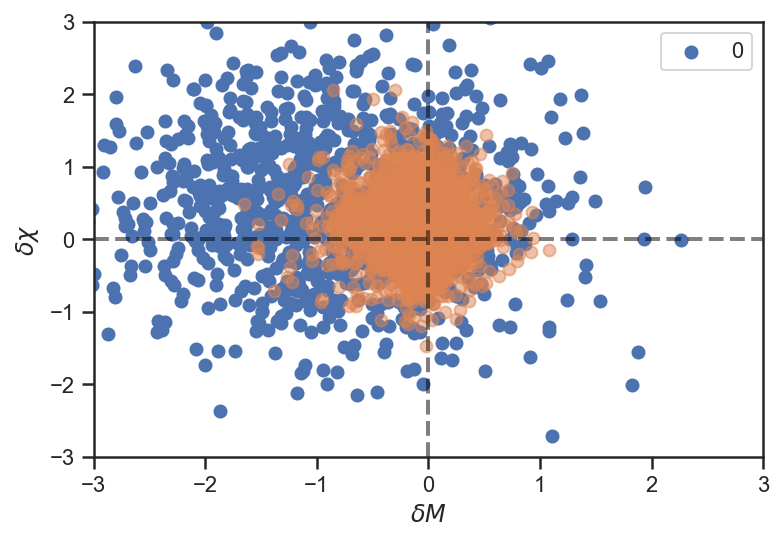

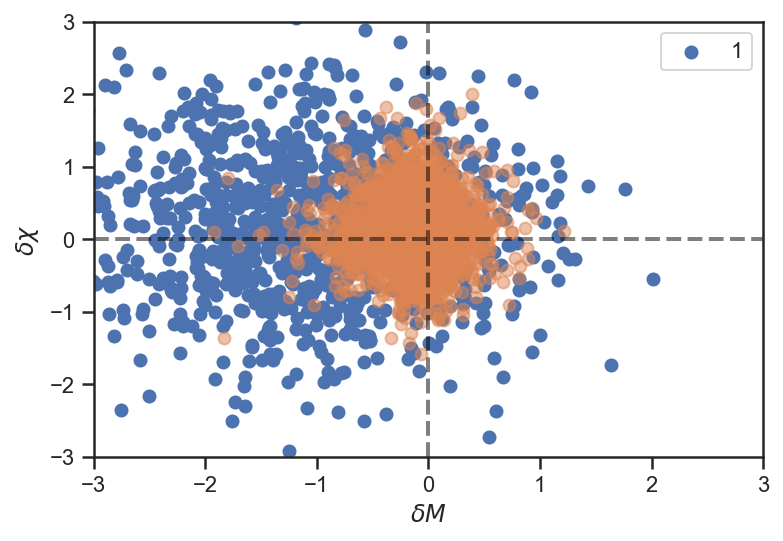

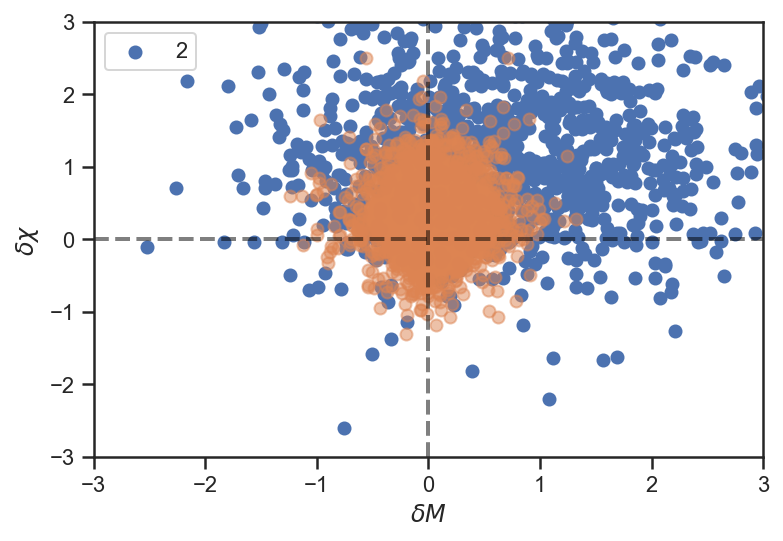

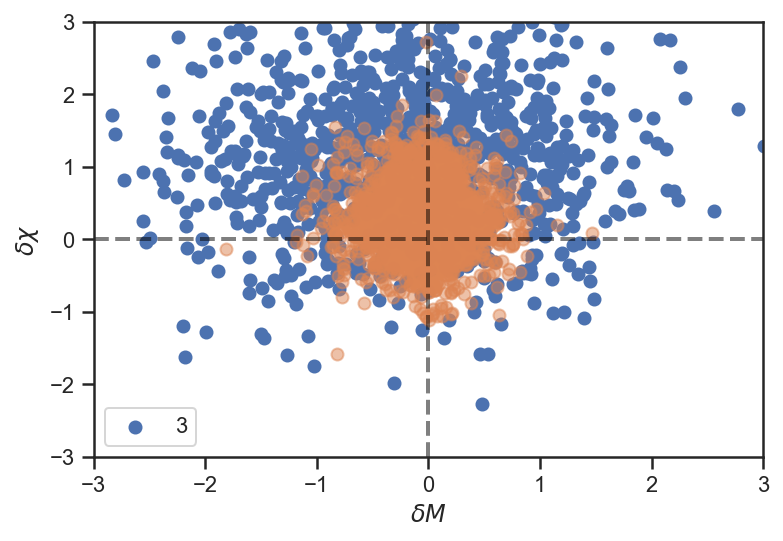

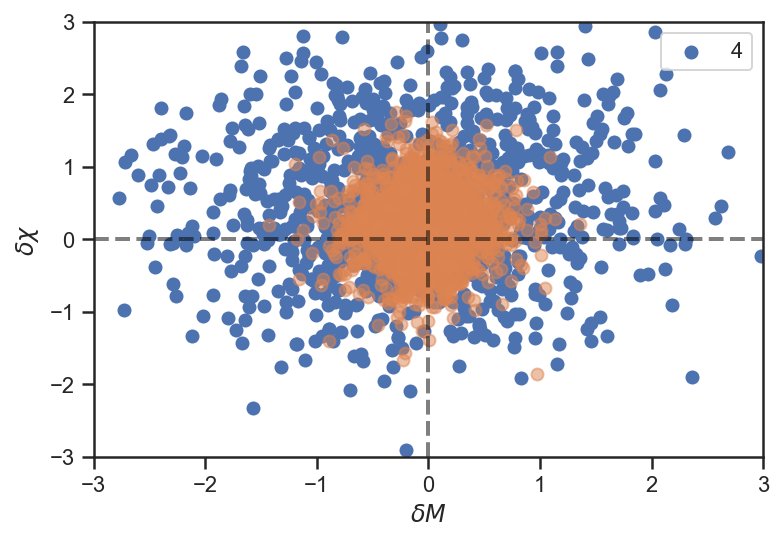

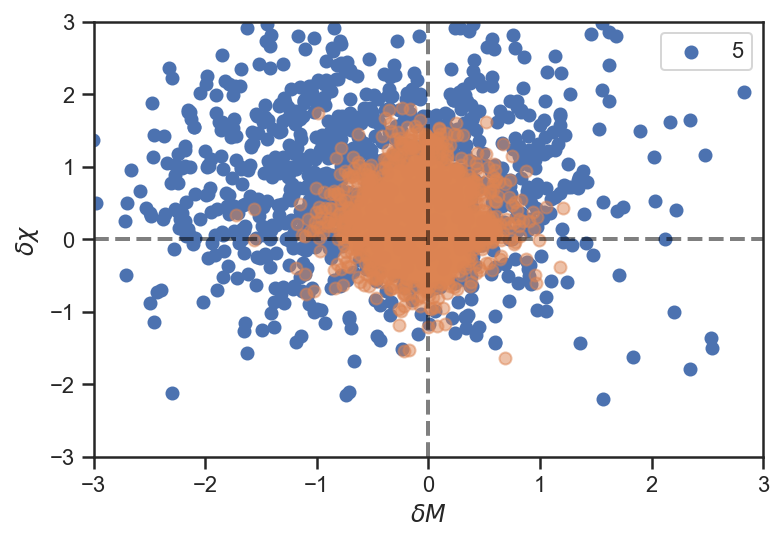

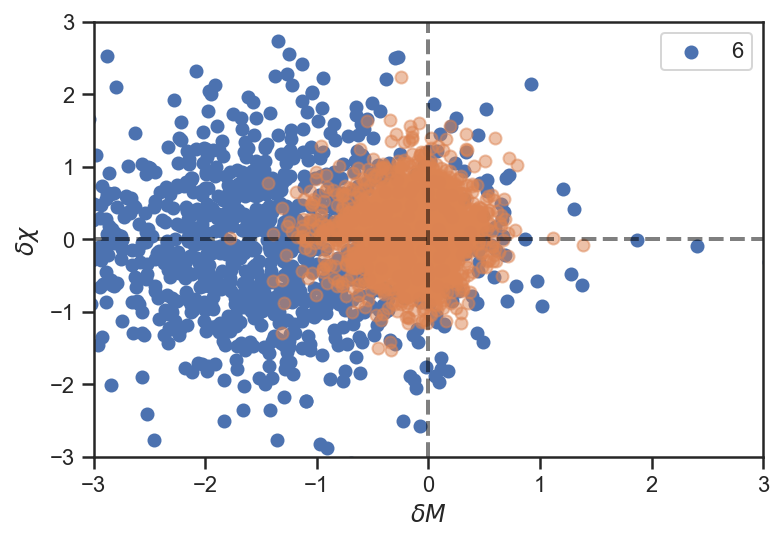

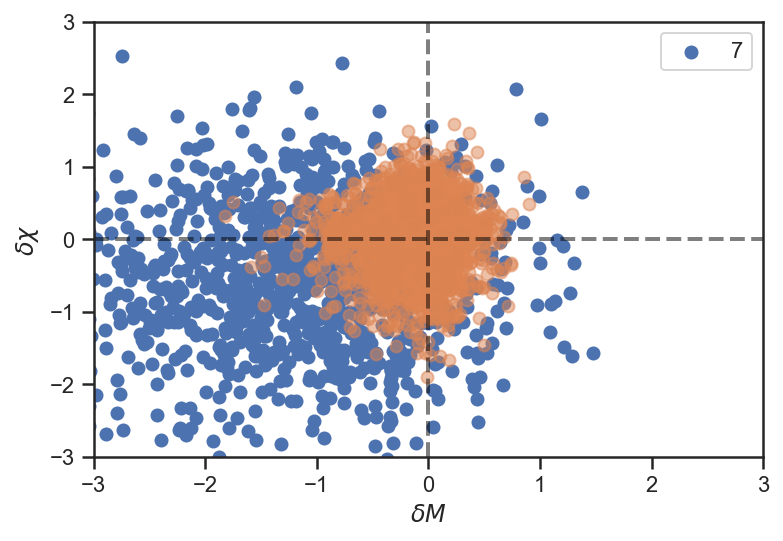

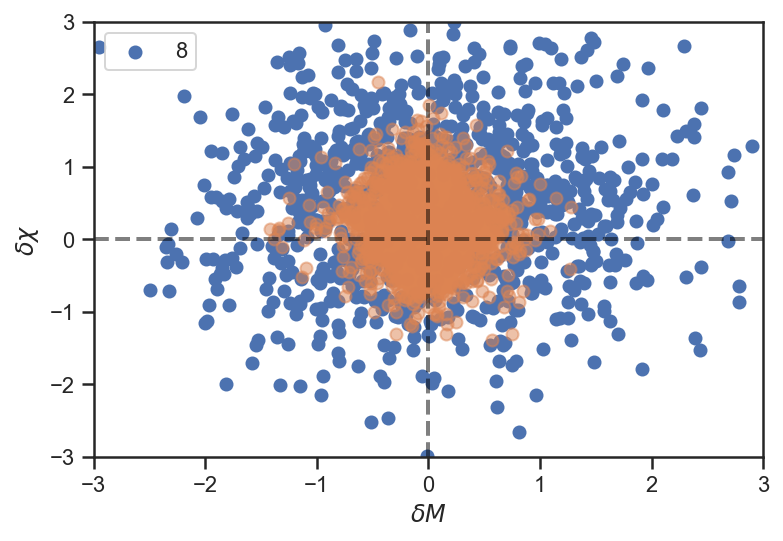

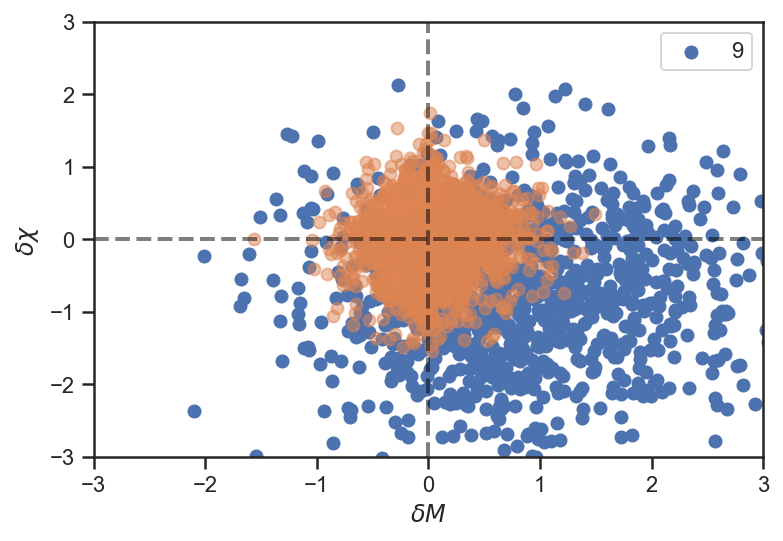

In [33]:
for i,event in enumerate(all_events[:10]):
    plt.scatter(dmchi_samples[event][0],
                dmchi_samples[event][1], label=event)
    plt.scatter(result.posterior.dMtrue.values[:,:,i].flatten(),
               result.posterior.dchitrue.values[:,:,i].flatten(),
               alpha=0.5)
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.axvline(0, c='k', ls='--', lw=2, alpha=0.5)
    plt.axhline(0, c='k', ls='--', lw=2, alpha=0.5)
    plt.xlabel(r'$\delta M$')
    plt.ylabel(r'$\delta \chi$')
    plt.legend()
    plt.show()

### Posterior on the distribution

Text(0, 0.5, '$\\mu_{\\delta \\chi}$')

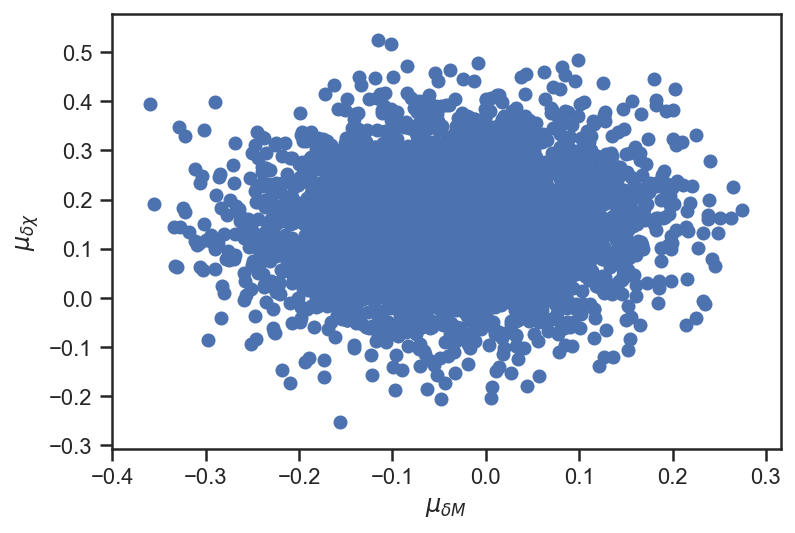

In [34]:
plt.scatter(result.posterior.Mu.values[:,:,0].flatten(),
           result.posterior.Mu.values[:,:,1].flatten())
xlabel(r'$\mu_{\delta M}$')
ylabel(r'$\mu_{\delta \chi}$')

# Paper plots

Plot "combined" result:

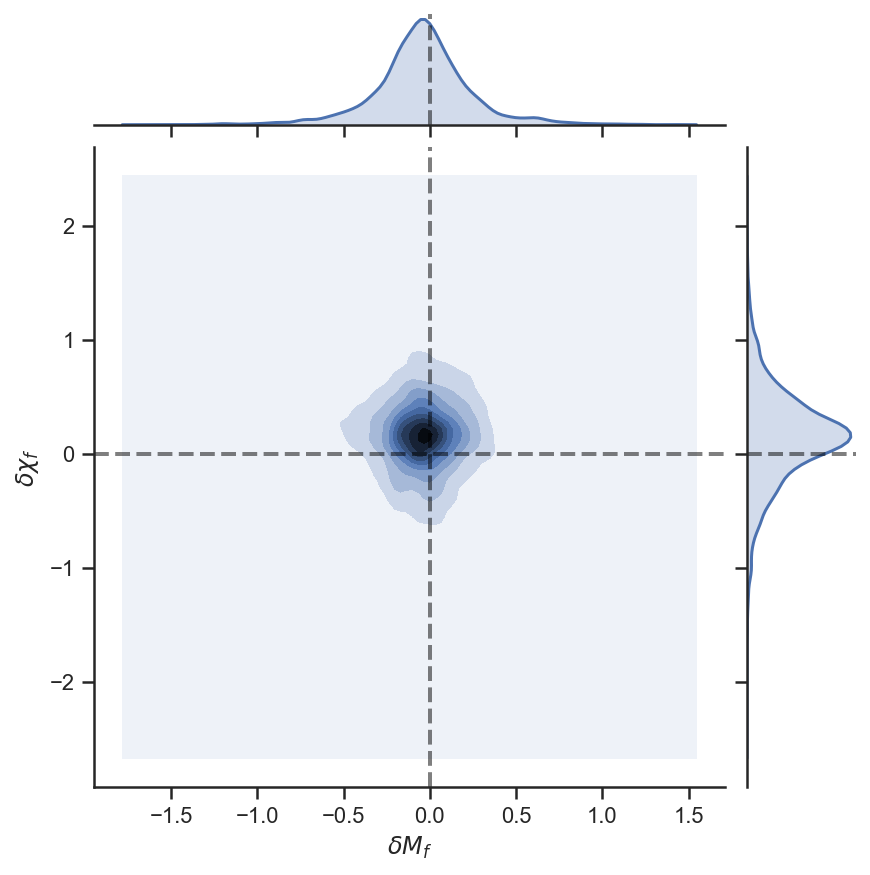

In [35]:
sns.set_palette('deep')

dm_draws = result.posterior.dMpop.values.flatten()
dchi_draws = result.posterior.dchipop.values.flatten()

g = sns.jointplot(dm_draws, dchi_draws, kind="kde")

g.ax_joint.set_xlabel(r'$\delta M_f$')
g.ax_joint.set_ylabel(r'$\delta \chi_f$')

g.ax_joint.axvline(0, ls='--', lw=2, c='k', alpha=0.5)
g.ax_joint.axhline(0, ls='--', lw=2, c='k', alpha=0.5)

g.ax_marg_x.axvline(0, ls='--', lw=2, c='k', alpha=0.5)
g.ax_marg_y.axhline(0, ls='--', lw=2, c='k', alpha=0.5)

plt.show()